In [1]:
#gpu stuff and testing
import os
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"
##############################################
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
##############################################
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

2.2.0
Num GPUs Available:  1
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [2]:
import pandas as pd
import numpy as np

# Getting to business!

## Neural Network

### ECFP/Morgan

In [4]:
#reshape morgan data
Xm= pd.read_csv('../Data/morgancolumns.csv')
file= pd.read_csv('../Data/tox21mice_duplicate.csv')
y=file[['SR-HSE', 'NR-AR','SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP', 'NR-ER','NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD']]

#splitting into train and test data
from sklearn.model_selection import train_test_split
Xm_train, Xm_test, y_train, y_test = train_test_split(Xm, y, test_size = 0.3, random_state = 21)
Xm_train_reshape= Xm_train.astype("float32")
Xm_test_reshape= Xm_test.astype("float32")

In [5]:
len(Xm_train)

8230

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
morganmodel = keras.Sequential(
    [
        layers.Embedding(len(Xm_train),128,name="embedding_layer", input_length= len(Xm.iloc[0])),
        layers.Dense(1300, activation="relu"),
        #layers.Dense(3, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(12,activation='sigmoid', name="Output_layer"),
    ]
)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:

In [11]:
morganmodel.summary()

#compile and fit the model
morganmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#fit to model
morganmodel.fit(Xm_train_reshape, y_train, epochs=10, batch_size=48, verbose=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 1024, 128)         1053440   
_________________________________________________________________
dense (Dense)                (None, 1024, 1300)        167700    
_________________________________________________________________
flatten (Flatten)            (None, 1331200)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1331200)           0         
_________________________________________________________________
Output_layer (Dense)         (None, 12)                15974412  
Total params: 17,195,552
Trainable params: 17,195,552
Non-trainable params: 0
_________________________________________________________________
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in d

In [12]:
#using model.predict to do thresholding
morganpred = morganmodel.predict(Xm_train_reshape)
morganpred= tf.dtypes.cast(morganpred>= 0.5, tf.int64)

#for training data
count=0
for i in range(len(y_train)):
    a= (y_train.iloc[i]==morganpred[i])
    for j in range(len(a)):
        if (y_train.iloc[i][j]==morganpred[i][j]):
            count= count+1
print("The accuracy for the training set is: ",(count)/(len(y_train)*12))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_4527 in device /job:localhost/replica:0/task:0/dev

In [13]:
morganpredtest= morganmodel.predict(Xm_test_reshape)
morganpredtest= tf.dtypes.cast(morganpredtest>= 0.5, tf.int64)
count=0
for i in range(len(y_test)):
    a= (y_test.iloc[i]==morganpredtest[i])
    for j in range(len(a)):
        if (y_test.iloc[i][j]==morganpredtest[i][j]):
            count= count+1
print("The accuracy for test score is: ", count/(len(y_test)*12))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
The accuracy for test score is:  0.9330120937263794


In [14]:
loss, acc= morganmodel.evaluate(Xm_test_reshape, y_test, batch_size=128)
loss

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_1463115 in device /job:localhost/replica:0/task:0/device:GPU:0
28/28 [==============================] - 1s 29ms/step - loss: 0.2363 - accurac

0.2362748235464096

### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
#X_topo_train, X_topo_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(Xm_train, y_train)
predict= classifier.predict(Xm_test)
count_misclassified = (y_test != predict).sum()
print("The number of wrongly predicted data is:\n",count_misclassified)
rfaccuracy_ecfp= 1-(count_misclassified/len(y_test))
print("The accuracy of random forest is:\n", rfaccuracy_ecfp)

The number of wrongly predicted data is:
 SR-HSE           181
NR-AR            126
SR-ARE           499
NR-Aromatase     212
NR-ER-LBD        156
NR-AhR           323
SR-MMP           400
NR-ER            346
NR-PPAR-gamma     80
SR-p53           221
SR-ATAD5          99
NR-AR-LBD        116
dtype: int64
The accuracy of random forest is:
 SR-HSE           0.948696
NR-AR            0.964286
SR-ARE           0.858560
NR-Aromatase     0.939909
NR-ER-LBD        0.955782
NR-AhR           0.908447
SR-MMP           0.886621
NR-ER            0.901927
NR-PPAR-gamma    0.977324
SR-p53           0.937358
SR-ATAD5         0.971939
NR-AR-LBD        0.967120
dtype: float64


### Logistic Regression

#### SR-HSE

In [17]:
from sklearn.linear_model import LogisticRegression
sr_hse= y_train['SR-HSE']
lm = LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(Xm_train, sr_hse)
taccuracy1= lm.score(Xm_test, y_test['SR-HSE'])
print("The accuracy of the model is:",taccuracy1)

The accuracy of the model is: 0.947562358276644


#### NR-AR 

In [18]:
nr_ar= y_train['NR-AR']
lm.fit(Xm_train, nr_ar)
taccuracy2= lm.score(Xm_test, y_test['NR-AR'])
print("The accuracy of the model is:",taccuracy2)

The accuracy of the model is: 0.9671201814058957


#### SR-ARE

In [19]:
sr_are= y_train['SR-ARE']
lm.fit(Xm_train, sr_are)
taccuracy3= lm.score(Xm_test, y_test['SR-ARE'])
print("The accuracy of the model is:",taccuracy3)

The accuracy of the model is: 0.8460884353741497


#### NR-Aromatase

In [20]:
nr_aromatase= y_train['NR-Aromatase']
lm.fit(Xm_train, nr_aromatase)
taccuracy4= lm.score(Xm_test, y_test['NR-Aromatase'])
print("The accuracy of the model is:",taccuracy4)

The accuracy of the model is: 0.9390589569160998


#### NR-ER-LBD

In [21]:
nr_erlbd= y_train['NR-ER-LBD']
lm.fit(Xm_train, nr_erlbd)
taccuracy5= lm.score(Xm_test, y_test['NR-ER-LBD'])
print("The accuracy of the model is:",taccuracy5)

The accuracy of the model is: 0.9589002267573696


#### NR-AhR

In [22]:
nr_ahr= y_train['NR-AhR']
lm.fit(Xm_train, nr_ahr)
taccuracy6= lm.score(Xm_test, y_test['NR-AhR'])
print("The accuracy of the model is:",taccuracy6)

The accuracy of the model is: 0.9061791383219955


#### SR-MMP

In [23]:
sr_mmp= y_train['SR-MMP']
lm.fit(Xm_train, sr_mmp)
taccuracy7= lm.score(Xm_test, y_test['SR-MMP'])
print("The accuracy of the model is:",taccuracy7)

The accuracy of the model is: 0.88718820861678


#### NR-ER

In [24]:
nr_er= y_train['NR-ER']
lm.fit(Xm_train, nr_er)
taccuracy8= lm.score(Xm_test, y_test['NR-ER'])
print("The accuracy of the model is:",taccuracy8)

The accuracy of the model is: 0.9030612244897959


#### NR-PPAR-gamma

In [25]:
nr_ppar= y_train['NR-PPAR-gamma']
lm.fit(Xm_train, nr_ppar)
taccuracy9= lm.score(Xm_test, y_test['NR-PPAR-gamma'])
print("The accuracy of the model is:",taccuracy9)

The accuracy of the model is: 0.9753401360544217


#### SR-p53

In [26]:
sr_p53= y_train['SR-p53']
lm.fit(Xm_train, sr_p53)
taccuracy10= lm.score(Xm_test, y_test['SR-p53'])
print("The accuracy of the model is:",taccuracy10)

The accuracy of the model is: 0.9339569160997733


#### SR-ATAD5

In [27]:
sr_atad5= y_train['SR-ATAD5']
lm.fit(Xm_train, sr_atad5)
taccuracy11= lm.score(Xm_test, y_test['SR-ATAD5'])
print("The accuracy of the model is:",taccuracy11)

The accuracy of the model is: 0.9705215419501134


#### NR-AR-LBD

In [28]:
nr_arlbd= y_train['NR-AR-LBD']
lm.fit(Xm_train, nr_arlbd)
taccuracy12= lm.score(Xm_test, y_test['NR-AR-LBD'])
print("The accuracy of the model is:",taccuracy12)

The accuracy of the model is: 0.969671201814059


### SVM

In [29]:
from sklearn import svm

#### SR-HSE

In [30]:
sr_hse= y_train['SR-HSE']
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovr')
sig.fit(Xm_train, sr_hse)
tsaccuracy1= sig.score(Xm_test, y_test['SR-HSE'])
print("The accuracy of the model is:",tsaccuracy1)

The accuracy of the model is: 0.9455782312925171


#### NR-AR 

In [31]:
nr_ar= y_train['NR-AR']
sig.fit(Xm_train, nr_ar)
tsaccuracy2= sig.score(Xm_test, y_test['NR-AR'])
print("The accuracy of the model is:",tsaccuracy2)

The accuracy of the model is: 0.969954648526077


#### SR-ARE

In [32]:
sr_are= y_train['SR-ARE']
sig.fit(Xm_train, sr_are)
tsaccuracy3= sig.score(Xm_test, y_test['SR-ARE'])
print("The accuracy of the model is:",tsaccuracy3)

The accuracy of the model is: 0.8398526077097506


#### NR-Aromatase

In [33]:
nr_aromatase= y_train['NR-Aromatase']
sig.fit(Xm_train, nr_aromatase)
tsaccuracy4= sig.score(Xm_test, y_test['NR-Aromatase'])
print("The accuracy of the model is:",tsaccuracy4)

The accuracy of the model is: 0.9390589569160998


#### NR-ER-LBD

In [34]:
nr_erlbd= y_train['NR-ER-LBD']
sig.fit(Xm_train, nr_erlbd)
tsaccuracy5= sig.score(Xm_test, y_test['NR-ER-LBD'])
print("The accuracy of the model is:",tsaccuracy5)

The accuracy of the model is: 0.9509637188208617


#### NR-AhR

In [35]:
nr_ahr= y_train['NR-AhR']
sig.fit(Xm_train, nr_ahr)
tsaccuracy6= sig.score(Xm_test, y_test['NR-AhR'])
print("The accuracy of the model is:",tsaccuracy6)

The accuracy of the model is: 0.9007936507936508


#### SR-MMP

In [36]:
sr_mmp= y_train['SR-MMP']
sig.fit(Xm_train, sr_mmp)
tsaccuracy7= sig.score(Xm_test, y_test['SR-MMP'])
print("The accuracy of the model is:",tsaccuracy7)

The accuracy of the model is: 0.8732993197278912


#### NR-ER

In [37]:
nr_er= y_train['NR-ER']
sig.fit(Xm_train, nr_er)
tsaccuracy8= sig.score(Xm_test, y_test['NR-ER'])
print("The accuracy of the model is:",tsaccuracy8)

The accuracy of the model is: 0.9024943310657596


#### NR-PPAR-gamma

In [38]:
nr_ppar= y_train['NR-PPAR-gamma']
sig.fit(Xm_train, nr_ppar)
tsaccuracy9= sig.score(Xm_test, y_test['NR-PPAR-gamma'])
print("The accuracy of the model is:",tsaccuracy9)

The accuracy of the model is: 0.9764739229024944


#### SR-p53

In [39]:
sr_p53= y_train['SR-p53']
sig.fit(Xm_train, sr_p53)
tsaccuracy10= sig.score(Xm_test, y_test['SR-p53'])
print("The accuracy of the model is:",tsaccuracy10)

The accuracy of the model is: 0.9362244897959183


#### SR-ATAD5

In [40]:
sr_atad5= y_train['SR-ATAD5']
sig.fit(Xm_train, sr_atad5)
tsaccuracy11= sig.score(Xm_test, y_test['SR-ATAD5'])
print("The accuracy of the model is:",tsaccuracy11)

The accuracy of the model is: 0.9682539682539683


#### NR-AR-LBD

In [41]:
nr_arlbd= y_train['NR-AR-LBD']
sig.fit(Xm_train, nr_arlbd)
tsaccuracy12= sig.score(Xm_test, y_test['NR-AR-LBD'])
print("The accuracy of the model is:",tsaccuracy12)

The accuracy of the model is: 0.9662698412698413


#### Summary of ecfp data

In [42]:
print("\033[1m" + "For Random Forest:"+ "\033[0m")
print(rfaccuracy_ecfp)
print("\033[0m"+"----------")
print("\033[1m" + "For SVM:"+ "\033[0m")
print("\033[1m" + "For Logistic Regression:" + "\033[0m")
print("SR-HSE: \t", taccuracy1)
print("NR-AR: \t", taccuracy2)
print("SR-ARE: \t", taccuracy3)
print("NR-Aromatase: \t", taccuracy4)
print("NR-ER-LBD: \t", taccuracy5)
print("NR-AhR: \t", taccuracy6)
print("SR-MMP: \t", taccuracy7)
print("NR-ER: \t", taccuracy8)
print("NR-PPAR-gamma: \t", taccuracy9)
print("SR-p53: \t", taccuracy10)
print("SR-ATAD5: \t", taccuracy11)
print("NR-AR-LBD: \t", taccuracy12)
print("\033[0m"+"----------")
print("\033[1m" + "For SVM:"+ "\033[0m")
print("SR-HSE: \t", tsaccuracy1)
print("NR-AR: \t", tsaccuracy2)
print("SR-ARE: \t", tsaccuracy3)
print("NR-Aromatase: \t", tsaccuracy4)
print("NR-ER-LBD: \t", tsaccuracy5)
print("NR-AhR: \t", tsaccuracy6)
print("SR-MMP: \t", tsaccuracy7)
print("NR-ER: \t", tsaccuracy8)
print("NR-PPAR-gamma: \t", tsaccuracy9)
print("SR-p53: \t", tsaccuracy10)
print("SR-ATAD5: \t", tsaccuracy11)
print("NR-AR-LBD: \t", tsaccuracy12)

For Random Forest:
SR-HSE           0.948696
NR-AR            0.964286
SR-ARE           0.858560
NR-Aromatase     0.939909
NR-ER-LBD        0.955782
NR-AhR           0.908447
SR-MMP           0.886621
NR-ER            0.901927
NR-PPAR-gamma    0.977324
SR-p53           0.937358
SR-ATAD5         0.971939
NR-AR-LBD        0.967120
dtype: float64
----------
For SVM:
For Logistic Regression:
SR-HSE: 	 0.947562358276644
NR-AR: 	 0.9671201814058957
SR-ARE: 	 0.8460884353741497
NR-Aromatase: 	 0.9390589569160998
NR-ER-LBD: 	 0.9589002267573696
NR-AhR: 	 0.9061791383219955
SR-MMP: 	 0.88718820861678
NR-ER: 	 0.9030612244897959
NR-PPAR-gamma: 	 0.9753401360544217
SR-p53: 	 0.9339569160997733
SR-ATAD5: 	 0.9705215419501134
NR-AR-LBD: 	 0.969671201814059
----------
For SVM:
SR-HSE: 	 0.9455782312925171
NR-AR: 	 0.969954648526077
SR-ARE: 	 0.8398526077097506
NR-Aromatase: 	 0.9390589569160998
NR-ER-LBD: 	 0.9509637188208617
NR-AhR: 	 0.9007936507936508
SR-MMP: 	 0.8732993197278912
NR-ER: 	 0.90249

## Feature Selection

### Random Forest Classifier

In [43]:
feature_importance= pd.DataFrame(classifier.feature_importances_,\
                                   index = Xm.columns,\
                                   columns=['importance']).sort_values('importance', ascending=False)
classifier.fit(Xm_train, y_train)
feature_scores = pd.Series(classifier.feature_importances_, index=Xm.columns).sort_values(ascending=False)

feature_scores

579    0.009679
81     0.008377
34     0.007846
876    0.007272
651    0.006720
         ...   
682    0.000092
720    0.000081
439    0.000064
31     0.000059
373    0.000041
Length: 1024, dtype: float64

In [44]:
classifier.fit(Xm_train, y_train)
feature_scores = pd.Series(classifier.feature_importances_, index=Xm.columns).sort_values(ascending=False)

feature_scores

579    0.009679
81     0.008377
34     0.007846
876    0.007272
651    0.006720
         ...   
682    0.000092
720    0.000081
439    0.000064
31     0.000059
373    0.000041
Length: 1024, dtype: float64

Text(0, 0.5, 'Number of Features (RFC)')

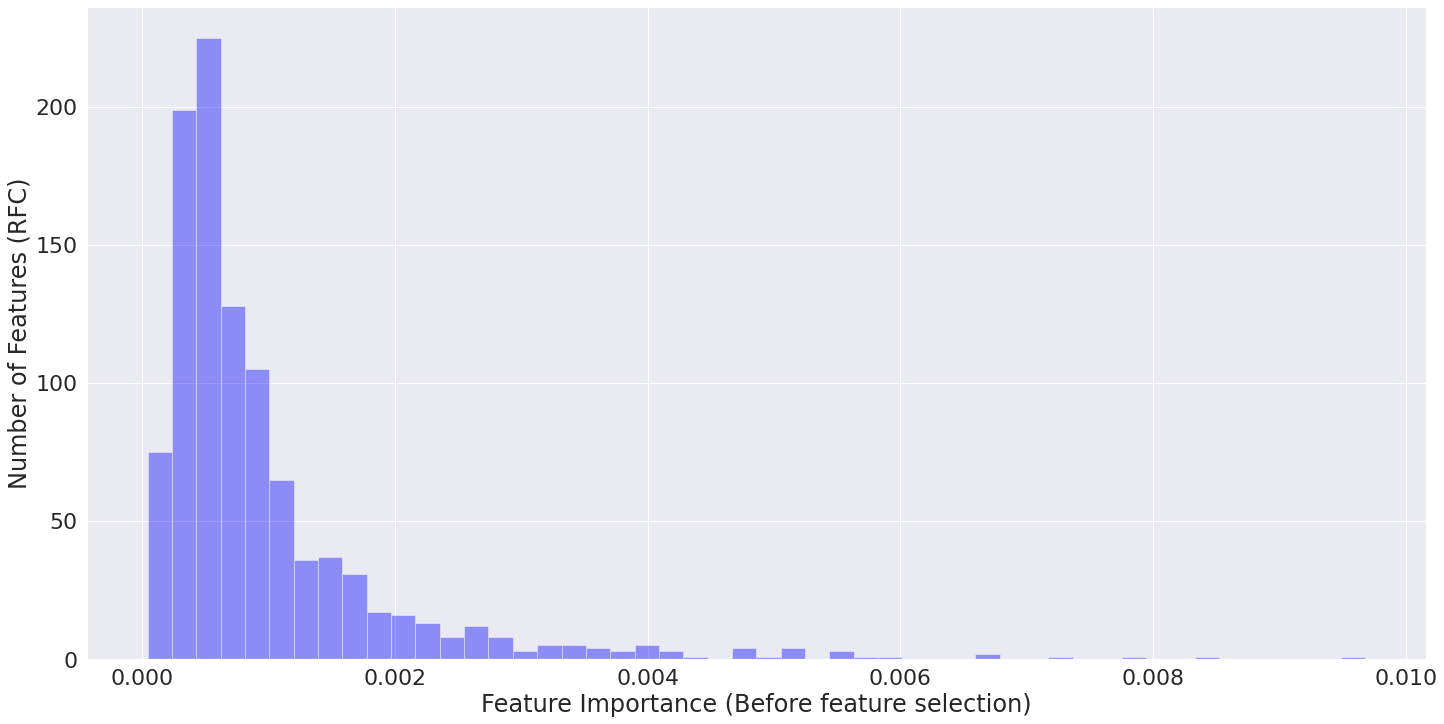

In [45]:
import seaborn as sb
import matplotlib.pyplot as plt
#histogram without feature selection
sb.set(font_scale=2)
f, axes = plt.subplots(1, 1, figsize=(24, 12))
a= sb.distplot(feature_scores, kde = False, color = "blue", axlabel="Feature Importance (Before feature selection)")
axes.set_ylabel("Number of Features (RFC)")

In [46]:
#select these indexes and get those respective features from X
features=feature_scores[0:100]
features

579    0.009679
81     0.008377
34     0.007846
876    0.007272
651    0.006720
         ...   
675    0.002077
839    0.002071
507    0.002070
729    0.002053
836    0.002034
Length: 100, dtype: float64

Text(0, 0.5, 'Number of Features (RFC)')

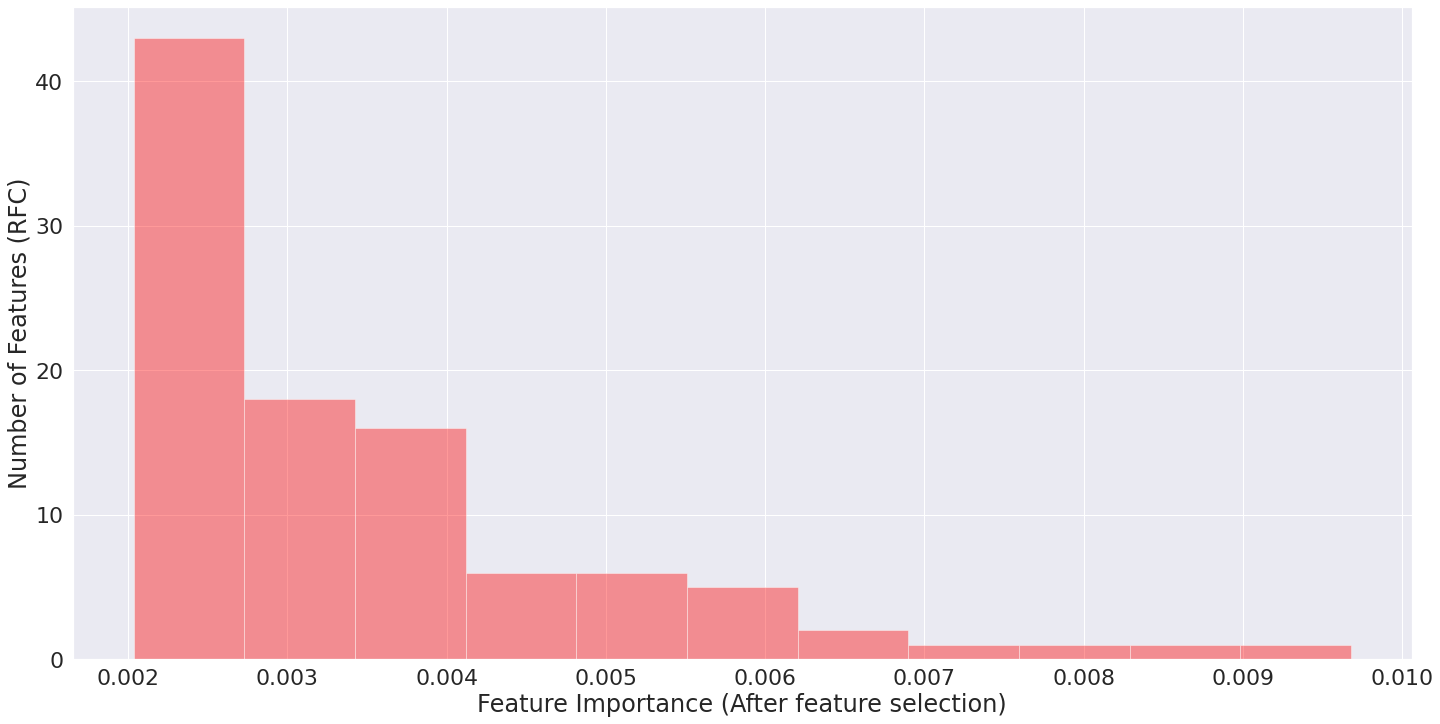

In [47]:
#plotting histogram for features after feature selection
import seaborn as sb
f, axes = plt.subplots(1, 1, figsize=(24, 12))
sb.distplot(features, kde = False, color = "red",axlabel="Feature Importance (After feature selection)")
axes.set_ylabel("Number of Features (RFC)")

#### After re-training the data

In [48]:
X_feat_train,X_feat_test,y_feat_train,y_feat_test=train_test_split(Xm[features.index],y,test_size=0.3,random_state=0)
newclassifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
newclassifier.fit(X_feat_train,y_feat_train)
newrfpredict=newclassifier.predict(X_feat_test)
count_misclassified = (y_feat_test != newrfpredict).sum()
newrfaccuracy= 1-(count_misclassified/len(y_feat_test))
newrfaccuracy

SR-HSE           0.951531
NR-AR            0.969104
SR-ARE           0.865363
NR-Aromatase     0.942177
NR-ER-LBD        0.955215
NR-AhR           0.911848
SR-MMP           0.891156
NR-ER            0.906179
NR-PPAR-gamma    0.972789
SR-p53           0.941610
SR-ATAD5         0.972789
NR-AR-LBD        0.972506
dtype: float64

In [49]:
print("\033[1m" + "Random Forest:"+ "\033[0m")
print("\033[1m" + "Before feature selection:"+ "\033[0m")
print(rfaccuracy_ecfp)
print("------------------")
print("\033[1m" + "After feature selection:"+ "\033[0m")
print(newrfaccuracy)

Random Forest:
Before feature selection:
SR-HSE           0.948696
NR-AR            0.964286
SR-ARE           0.858560
NR-Aromatase     0.939909
NR-ER-LBD        0.955782
NR-AhR           0.908447
SR-MMP           0.886621
NR-ER            0.901927
NR-PPAR-gamma    0.977324
SR-p53           0.937358
SR-ATAD5         0.971939
NR-AR-LBD        0.967120
dtype: float64
------------------
After feature selection:
SR-HSE           0.951531
NR-AR            0.969104
SR-ARE           0.865363
NR-Aromatase     0.942177
NR-ER-LBD        0.955215
NR-AhR           0.911848
SR-MMP           0.891156
NR-ER            0.906179
NR-PPAR-gamma    0.972789
SR-p53           0.941610
SR-ATAD5         0.972789
NR-AR-LBD        0.972506
dtype: float64


In [87]:
sum =0
for x in range(len(rfaccuracy_ecfp)):
    sum= sum+ rfaccuracy_ecfp[x]
average= sum/12
print("Average accuracy score before feature selection is ", average)

Average accuracy score before feature selection is  0.9348308767951625


In [88]:
sum=0
for x in range(len(newrfaccuracy)):
    sum= sum+ newrfaccuracy[x]
average= sum/12
print("Average accuracy score after feature selection is ", average)

Average accuracy score after feature selection is  0.9376889644746784


### RFE

In [50]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

This will take a really long while

In [51]:
rfe = RFE(lm, n_features_to_select= 100)
rfe = rfe.fit(Xm, y['SR-HSE'])

In [52]:
len(rfe.ranking_)

1024

In [53]:
rfe.ranking_

array([381, 765, 844, ..., 847, 471, 715])

In [54]:
rfe.ranking_.sum()

428374

In [55]:
rf_rerank= rfe.ranking_/len(rfe.ranking_)
rf_rerank[1]

0.7470703125

In [56]:
feature_importance= pd.DataFrame(rfe.ranking_,\
                                   index = Xm.columns,\
                                   columns=['importance']).sort_values('importance', ascending=True)
feature_importance.round(6)

,importance
240,1
322,1
117,1
606,1
114,1
...,...
228,921
1020,922
941,923
710,924


In [57]:
feat_sel= feature_importance[0:100]
feat_sel

,importance
240,1
322,1
117,1
606,1
114,1
...,...
666,1
403,1
501,1
665,1


If ranking=1, it means that it is the best feature!

In [58]:
Xm[feat_sel.index]

,240,322,117,606,114,990,111,602,332,334,...,910,19,541,1014,500,666,403,501,665,39
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11753,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
Xt_rfe_train,Xt_rfe_test,yt_rfe_train,yt_rfe_test=train_test_split(Xm[feat_sel.index],y,test_size=0.3,random_state=0)

#### SR-HSE

In [60]:
sr_hse= yt_rfe_train['SR-HSE']
lm.fit(Xt_rfe_train, sr_hse)
newtaccuracy1=lm.score(Xt_rfe_test, yt_rfe_test['SR-HSE'])
print("The accuracy of the model is:",newtaccuracy1)

The accuracy of the model is: 0.9489795918367347


#### NR-AR 

In [61]:
nr_ar= yt_rfe_train['NR-AR']
lm.fit(Xt_rfe_train, nr_ar)
newtaccuracy2= lm.score(Xt_rfe_test, yt_rfe_test['NR-AR'])
print("The accuracy of the model is:",newtaccuracy2)

The accuracy of the model is: 0.969671201814059


#### SR-ARE

In [62]:
sr_are= yt_rfe_train['SR-ARE']
lm.fit(Xt_rfe_train, sr_are)
newtaccuracy3= lm.score(Xt_rfe_test, yt_rfe_test['SR-ARE'])
print("The accuracy of the model is:",newtaccuracy3)

The accuracy of the model is: 0.8562925170068028


#### NR-Aromatase

In [63]:
nr_aromatase= yt_rfe_train['NR-Aromatase']
lm.fit(Xt_rfe_train, nr_aromatase)
newtaccuracy4= lm.score(Xt_rfe_test, yt_rfe_test['NR-Aromatase'])
print("The accuracy of the model is:",newtaccuracy4)

The accuracy of the model is: 0.9433106575963719


#### NR-ER-LBD

In [64]:
nr_erlbd= yt_rfe_train['NR-ER-LBD']
lm.fit(Xt_rfe_train, nr_erlbd)
newtaccuracy5= lm.score(Xt_rfe_test, yt_rfe_test['NR-ER-LBD'])
print("The accuracy of the model is:",newtaccuracy5)

The accuracy of the model is: 0.9498299319727891


#### NR-AhR

In [65]:
nr_ahr= yt_rfe_train['NR-AhR']
lm.fit(Xt_rfe_train, nr_ahr)
newtaccuracy6= lm.score(Xt_rfe_test, yt_rfe_test['NR-AhR'])
print("The accuracy of the model is:",newtaccuracy6)

The accuracy of the model is: 0.9084467120181405


#### SR-MMP

In [66]:
sr_mmp= yt_rfe_train['SR-MMP']
lm.fit(Xt_rfe_train, sr_mmp)
newtaccuracy7= lm.score(Xt_rfe_test, yt_rfe_test['SR-MMP'])
print("The accuracy of the model is:",newtaccuracy7)

The accuracy of the model is: 0.8832199546485261


#### NR-ER

In [67]:
nr_er= yt_rfe_train['NR-ER']
lm.fit(Xt_rfe_train, nr_er)
newtaccuracy8= lm.score(Xt_rfe_test, yt_rfe_test['NR-ER'])
print("The accuracy of the model is:",newtaccuracy8)

The accuracy of the model is: 0.9058956916099773


#### NR-PPAR-gamma

In [68]:
nr_ppar= yt_rfe_train['NR-PPAR-gamma']
lm.fit(Xt_rfe_train, nr_ppar)
newtaccuracy9= lm.score(Xt_rfe_test, yt_rfe_test['NR-PPAR-gamma'])
print("The accuracy of the model is:",newtaccuracy9)

The accuracy of the model is: 0.9747732426303855


#### SR-p53

In [69]:
sr_p53= yt_rfe_train['SR-p53']
lm.fit(Xt_rfe_train, sr_p53)
newtaccuracy10= lm.score(Xt_rfe_test, yt_rfe_test['SR-p53'])
print("The accuracy of the model is:",newtaccuracy10)

The accuracy of the model is: 0.94359410430839


#### SR-ATAD5

In [70]:
sr_atad5= yt_rfe_train['SR-ATAD5']
lm.fit(Xt_rfe_train, sr_atad5)
newtaccuracy11= lm.score(Xt_rfe_test, yt_rfe_test['SR-ATAD5'])
print("The accuracy of the model is:",newtaccuracy11)

The accuracy of the model is: 0.971655328798186


#### NR-AR-LBD

In [71]:
nr_arlbd= yt_rfe_train['NR-AR-LBD']
lm.fit(Xt_rfe_train, nr_arlbd)
newtaccuracy12= lm.score(Xt_rfe_test, yt_rfe_test['NR-AR-LBD'])
print("The accuracy of the model is:",newtaccuracy12)

The accuracy of the model is: 0.971655328798186


In [89]:
print("\033[1m" + "Logistic Regression:" + "\033[0m")
print("\033[1m" + "Before Feature Selection:" + "\033[0m")
print("SR-HSE: \t", taccuracy1)
print("NR-AR: \t", taccuracy2)
print("SR-ARE: \t", taccuracy3)
print("NR-Aromatase: \t", taccuracy4)
print("NR-ER-LBD: \t", taccuracy5)
print("NR-AhR: \t", taccuracy6)
print("SR-MMP: \t", taccuracy7)
print("NR-ER: \t", taccuracy8)
print("NR-PPAR-gamma: \t", taccuracy9)
print("SR-p53: \t", taccuracy10)
print("SR-ATAD5: \t", taccuracy11)
print("NR-AR-LBD: \t", taccuracy12)
print("Average: \t", (taccuracy1+taccuracy2+taccuracy3+taccuracy4+taccuracy5+taccuracy6+taccuracy7+taccuracy8+taccuracy9+taccuracy10+taccuracy11+taccuracy12)/12)
print("------------------------------\n")
print("\033[1m" + "After Feature Selection:" + "\033[0m")
print("SR-HSE: \t", newtaccuracy1)
print("NR-AR: \t", newtaccuracy2)
print("SR-ARE: \t", newtaccuracy3)
print("NR-Aromatase: \t", newtaccuracy4)
print("NR-ER-LBD: \t", newtaccuracy5)
print("NR-AhR: \t", newtaccuracy6)
print("SR-MMP: \t", newtaccuracy7)
print("NR-ER: \t", newtaccuracy8)
print("NR-PPAR-gamma: \t", newtaccuracy9)
print("SR-p53: \t", newtaccuracy10)
print("SR-ATAD5: \t", newtaccuracy11)
print("NR-AR-LBD: \t", newtaccuracy12)
print("Average: \t", (newtaccuracy1+newtaccuracy2+newtaccuracy3+newtaccuracy4+newtaccuracy5+newtaccuracy6+newtaccuracy7+newtaccuracy8+newtaccuracy9+newtaccuracy10+newtaccuracy11+newtaccuracy12)/12)


Logistic Regression:
Before Feature Selection:
SR-HSE: 	 0.947562358276644
NR-AR: 	 0.9671201814058957
SR-ARE: 	 0.8460884353741497
NR-Aromatase: 	 0.9390589569160998
NR-ER-LBD: 	 0.9589002267573696
NR-AhR: 	 0.9061791383219955
SR-MMP: 	 0.88718820861678
NR-ER: 	 0.9030612244897959
NR-PPAR-gamma: 	 0.9753401360544217
SR-p53: 	 0.9339569160997733
SR-ATAD5: 	 0.9705215419501134
NR-AR-LBD: 	 0.969671201814059
Average: 	 0.9337207105064248
------------------------------

After Feature Selection:
SR-HSE: 	 0.9489795918367347
NR-AR: 	 0.969671201814059
SR-ARE: 	 0.8562925170068028
NR-Aromatase: 	 0.9433106575963719
NR-ER-LBD: 	 0.9498299319727891
NR-AhR: 	 0.9084467120181405
SR-MMP: 	 0.8832199546485261
NR-ER: 	 0.9058956916099773
NR-PPAR-gamma: 	 0.9747732426303855
SR-p53: 	 0.94359410430839
SR-ATAD5: 	 0.971655328798186
NR-AR-LBD: 	 0.971655328798186
Average: 	 0.9356103552532123


### Re-training SVM SVC

Was not able to use my sig model to re-train the features as some error popped up. Error mentioned that the model didn't have a coeff_, but it does

#### SR-HSE

In [74]:
sr_hse= yt_rfe_train['SR-HSE']
sig.fit(Xt_rfe_train, sr_hse)
newtsaccuracy1=sig.score(Xt_rfe_test, yt_rfe_test['SR-HSE'])
print("The accuracy of the model is:",newtsaccuracy1)

The accuracy of the model is: 0.9305555555555556


#### NR-AR 

In [75]:
nr_ar= yt_rfe_train['NR-AR']
sig.fit(Xt_rfe_train, nr_ar)
newtsaccuracy2= sig.score(Xt_rfe_test, yt_rfe_test['NR-AR'])
print("The accuracy of the model is:",newtsaccuracy2)

The accuracy of the model is: 0.9642857142857143


#### SR-ARE

In [76]:
sr_are= yt_rfe_train['SR-ARE']
sig.fit(Xt_rfe_train, sr_are)
newtsaccuracy3= sig.score(Xt_rfe_test, yt_rfe_test['SR-ARE'])
print("The accuracy of the model is:",newtsaccuracy3)

The accuracy of the model is: 0.8202947845804989


#### NR-Aromatase

In [77]:
nr_aromatase= yt_rfe_train['NR-Aromatase']
sig.fit(Xt_rfe_train, nr_aromatase)
newtsaccuracy4= sig.score(Xt_rfe_test, yt_rfe_test['NR-Aromatase'])
print("The accuracy of the model is:",newtsaccuracy4)

The accuracy of the model is: 0.9271541950113379


#### NR-ER-LBD

In [78]:
nr_erlbd= yt_rfe_train['NR-ER-LBD']
sig.fit(Xt_rfe_train, nr_erlbd)
newtsaccuracy5= sig.score(Xt_rfe_test, yt_rfe_test['NR-ER-LBD'])
print("The accuracy of the model is:",newtsaccuracy5)

The accuracy of the model is: 0.9387755102040817


#### NR-AhR

In [79]:
nr_ahr= yt_rfe_train['NR-AhR']
sig.fit(Xt_rfe_train, nr_ahr)
newtsaccuracy6= sig.score(Xt_rfe_test, yt_rfe_test['NR-AhR'])
print("The accuracy of the model is:",newtsaccuracy6)

The accuracy of the model is: 0.8900226757369615


#### SR-MMP

In [80]:
sr_mmp= yt_rfe_train['SR-MMP']
sig.fit(Xt_rfe_train, sr_mmp)
newtsaccuracy7= sig.score(Xt_rfe_test, yt_rfe_test['SR-MMP'])
print("The accuracy of the model is:",newtsaccuracy7)

The accuracy of the model is: 0.8594104308390023


#### NR-ER

In [81]:
nr_er= yt_rfe_train['NR-ER']
sig.fit(Xt_rfe_train, nr_er)
newtsaccuracy8= sig.score(Xt_rfe_test, yt_rfe_test['NR-ER'])
print("The accuracy of the model is:",newtsaccuracy8)

The accuracy of the model is: 0.8837868480725624


#### NR-PPAR-gamma

In [82]:
nr_ppar= yt_rfe_train['NR-PPAR-gamma']
sig.fit(Xt_rfe_train, nr_ppar)
newtsaccuracy9= sig.score(Xt_rfe_test, yt_rfe_test['NR-PPAR-gamma'])
print("The accuracy of the model is:",newtsaccuracy9)

The accuracy of the model is: 0.9702380952380952


#### SR-p53

In [83]:
sr_p53= yt_rfe_train['SR-p53']
sig.fit(Xt_rfe_train, sr_p53)
newtsaccuracy10= sig.score(Xt_rfe_test, yt_rfe_test['SR-p53'])
print("The accuracy of the model is:",newtsaccuracy10)

The accuracy of the model is: 0.9271541950113379


#### SR-ATAD5

In [84]:
sr_atad5= yt_rfe_train['SR-ATAD5']
sig.fit(Xt_rfe_train, sr_atad5)
newtsaccuracy11= sig.score(Xt_rfe_test, yt_rfe_test['SR-ATAD5'])
print("The accuracy of the model is:",newtsaccuracy11)

The accuracy of the model is: 0.9662698412698413


#### NR-AR-LBD

In [85]:
nr_arlbd= yt_rfe_train['NR-AR-LBD']
sig.fit(Xt_rfe_train, nr_arlbd)
newtsaccuracy12= sig.score(Xt_rfe_test, yt_rfe_test['NR-AR-LBD'])
print("The accuracy of the model is:",newtsaccuracy12)

The accuracy of the model is: 0.9617346938775511


In [86]:
print("\033[1m" + "SVM SC Regression:" + "\033[0m")
print("\033[1m" + "Before Feature Selection:" + "\033[0m")
print("SR-HSE: \t", tsaccuracy1)
print("NR-AR: \t", tsaccuracy2)
print("SR-ARE: \t", tsaccuracy3)
print("NR-Aromatase: \t", tsaccuracy4)
print("NR-ER-LBD: \t", tsaccuracy5)
print("NR-AhR: \t", tsaccuracy6)
print("SR-MMP: \t", tsaccuracy7)
print("NR-ER: \t", tsaccuracy8)
print("NR-PPAR-gamma: \t", tsaccuracy9)
print("SR-p53: \t", tsaccuracy10)
print("SR-ATAD5: \t", tsaccuracy11)
print("NR-AR-LBD: \t", tsaccuracy12)
print("Average: \t", (tsaccuracy1+tsaccuracy2+tsaccuracy3+tsaccuracy4+tsaccuracy5+tsaccuracy6+tsaccuracy7+tsaccuracy8+tsaccuracy9+tsaccuracy10+tsaccuracy11+tsaccuracy12)/12)
print("------------------------------\n")
print("\033[1m" + "After Feature Selection:" + "\033[0m")
print("SR-HSE: \t", newtsaccuracy1)
print("NR-AR: \t", newtsaccuracy2)
print("SR-ARE: \t", newtsaccuracy3)
print("NR-Aromatase: \t", newtsaccuracy4)
print("NR-ER-LBD: \t", newtsaccuracy5)
print("NR-AhR: \t", newtsaccuracy6)
print("SR-MMP: \t", newtsaccuracy7)
print("NR-ER: \t", newtsaccuracy8)
print("NR-PPAR-gamma: \t", newtsaccuracy9)
print("SR-p53: \t", newtsaccuracy10)
print("SR-ATAD5: \t", newtsaccuracy11)
print("NR-AR-LBD: \t", newtsaccuracy12)
print("Average: \t", (newtsaccuracy1+newtsaccuracy2+newtsaccuracy3+newtsaccuracy4+newtsaccuracy5+newtsaccuracy6+newtsaccuracy7+newtsaccuracy8+newtsaccuracy9+newtsaccuracy10+newtsaccuracy11+newtsaccuracy12)/12)

SVM SC Regression:
Before Feature Selection:
SR-HSE: 	 0.9455782312925171
NR-AR: 	 0.969954648526077
SR-ARE: 	 0.8398526077097506
NR-Aromatase: 	 0.9390589569160998
NR-ER-LBD: 	 0.9509637188208617
NR-AhR: 	 0.9007936507936508
SR-MMP: 	 0.8732993197278912
NR-ER: 	 0.9024943310657596
NR-PPAR-gamma: 	 0.9764739229024944
SR-p53: 	 0.9362244897959183
SR-ATAD5: 	 0.9682539682539683
NR-AR-LBD: 	 0.9662698412698413
Average: 	 0.9307681405895694
------------------------------

After Feature Selection:
SR-HSE: 	 0.9305555555555556
NR-AR: 	 0.9642857142857143
SR-ARE: 	 0.8202947845804989
NR-Aromatase: 	 0.9271541950113379
NR-ER-LBD: 	 0.9387755102040817
NR-AhR: 	 0.8900226757369615
SR-MMP: 	 0.8594104308390023
NR-ER: 	 0.8837868480725624
NR-PPAR-gamma: 	 0.9702380952380952
SR-p53: 	 0.9271541950113379
SR-ATAD5: 	 0.9662698412698413
NR-AR-LBD: 	 0.9617346938775511
Average: 	 0.9199735449735451


### Re-training Neural Network

Using features from **RFE**

In [ ]:
Xt_rfe_train,Xt_rfe_test,yt_rfe_train,yt_rfe_test

In [90]:
from tensorflow import keras
from tensorflow.keras import layers
newmorganmodel = keras.Sequential(
    [
        layers.Embedding(len(Xm_train),128,name="embedding_layer", input_length= len(Xt_rfe_train.iloc[0])),
        layers.Dense(1300, activation="relu"),
        #layers.Dense(3, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(12,activation='sigmoid', name="Output_layer"),
    ]
)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [91]:
newmorganmodel.summary()

#compile and fit the model
newmorganmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#fit to model
newmorganmodel.fit(Xt_rfe_train, yt_rfe_train, epochs=10, batch_size=48, verbose=0.1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 100, 128)          1053440   
_________________________________________________________________
dense_1 (Dense)              (None, 100, 1300)         167700    
_________________________________________________________________
flatten_1 (Flatten)          (None, 130000)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 130000)            0         
_________________________________________________________________
Output_layer (Dense)         (None, 12)                1560012   
Total params: 2,781,152
Trainable params: 2,781,152
Non-trainable params: 0
_________________________________________________________________
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in

In [92]:
#using model.predict to do thresholding
newmorganpred = newmorganmodel.predict(Xt_rfe_train)
newmorganpred= tf.dtypes.cast(newmorganpred>= 0.5, tf.int64)

#for training data
count=0
for i in range(len(yt_rfe_train)):
    a= (yt_rfe_train.iloc[i]==newmorganpred[i])
    for j in range(len(a)):
        if (yt_rfe_train.iloc[i][j]==newmorganpred[i][j]):
            count= count+1
print("The accuracy for the training set is: ",(count)/(len(yt_rfe_train)*12))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_1467695 in device /job:localhost/replica:0/task:0/

In [94]:
newmorganpredtest= newmorganmodel.predict(Xt_rfe_test)
newmorganpredtest= tf.dtypes.cast(newmorganpredtest>= 0.5, tf.int64)
count=0
for i in range(len(yt_rfe_test)):
    a= (yt_rfe_test.iloc[i]==newmorganpredtest[i])
    for j in range(len(a)):
        if (yt_rfe_test.iloc[i][j]==newmorganpredtest[i][j]):
            count= count+1
print("The accuracy for test score is: ", count/(len(yt_rfe_test)*12))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
The accuracy for test score is:  0.9355867346938775


In [96]:
loss, acc= newmorganmodel.evaluate(Xt_rfe_test, yt_rfe_test, batch_size=128)
loss

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_3364023 in device /job:localhost/replica:0/task:0/device:GPU:0
28/28 [==============================] - 0s 6ms/step - loss: 0.2089 - accuracy

0.20894809067249298

---